In [22]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


In [23]:
import numpy as np
import pandas as pd
import utm
import polars as pl

from shapely.geometry import Point, Polygon, LineString
from src.data_analysis import AnalysisRadar
from innosent_api.utils.approach_info import ApproachInfo


## Creating Radar Objects


In [24]:
radar_info = {
    "Radar 137": {
        "KML": ROOT / "geodata" / "Radar137.kml",
        # "Data": ROOT / "Data" / "Radar 137.parquet",
        "Data": "",
    },
    "Radar 136": {
        "KML": ROOT / "geodata" / "Radar136.kml",
        # "Data": ROOT / "Data" / "Radar 136.parquet",
        "Data": "",
    },
}


In [25]:
radars = [
    AnalysisRadar(str(r_info[1]["KML"]), r_info[0]) for r_info in radar_info.items()
]

radars = {radar.name: radar for radar in radars}


Radar 137
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Radar 136
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Get the Data from Polars


In [26]:
radars_df = pl.scan_parquet(
    "/Volumes/BittleLab/7 DOE Project/radar-data/new-format/13_*.parquet"
)

# # only keep data thats within start and end time
radars_df = (
    radars_df.with_columns(
        [pl.col("_time").dt.with_time_zone("America/Chicago").alias("time_cst")]
    )
    .filter(
        (pl.col("time_cst").dt.hour() >= 5)
        & (pl.col("time_cst").dt.hour() <= 12)
        & (pl.col("time_cst").dt.day() == 13)
    )
    .collect()
)

# drop any duplicates
radars_df = radars_df.groupby(by=["radar", "ui32_objectID", "_time"]).first()

radars_df = radars_df.sort("_time")


def get_df_from_polars(radar: AnalysisRadar, pl_df: pl.DataFrame) -> pd.DataFrame:
    ip_address = f"10.160.7.{radar.name.split('radar')[-1].strip()}"
    df = pl_df.filter(pl.col("radar") == ip_address)

    return df.to_pandas()


In [27]:
# radars_df.groupby(
#     by=["radar", "ui32_objectID",]
# ).agg(
#     (pl.col("time").sort() / 1e9).diff().mean().alias("time_diff")
# ).select('time_diff').to_pandas().hist()


array([[<AxesSubplot: title={'center': 'time_diff'}>]], dtype=object)

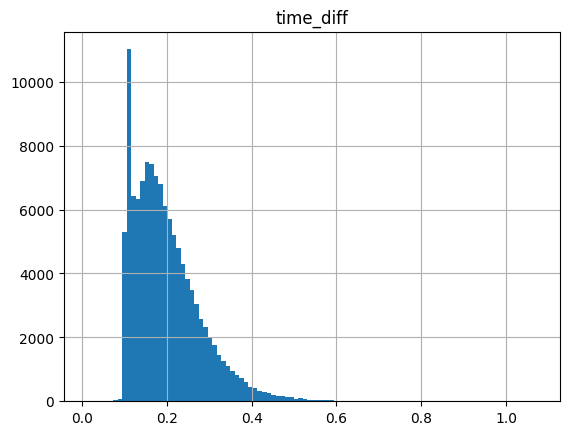

In [28]:
radars_df.groupby(
    by=["radar", "ui32_objectID",]
).agg(
    (pl.col("_time").sort() / 1e9).diff().mean().alias("time_diff")
).select('time_diff').to_pandas().hist(bins=100)


## Read in the Radar Data


In [29]:
for r_name, radar in radars.items():
    radar.df = get_df_from_polars(radar, radars_df)
    # convert the x/y to lat/lon
    radar.radar_xy_2_latlon()
    # convert to rw time
    # radar.apply_rw_time()
    radar.df["dt"] = radar.df.pop("time_cst")
    # label boxes
    radar.label_boxes()


<AxesSubplot: >

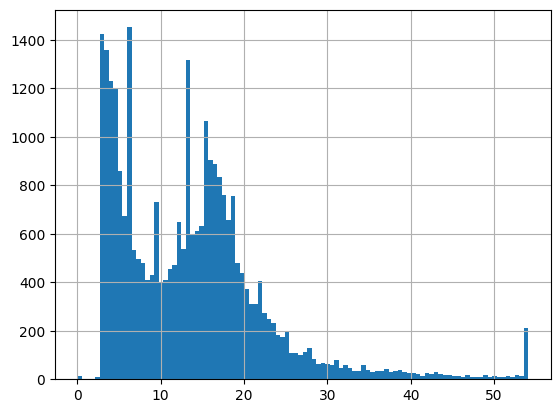

In [30]:
(radars['radar137'].df.groupby('ui32_objectID')['f32_length_m'].median() * 3.28084).hist(bins=100)

In [31]:
radars['radar137'].df.groupby('ui32_objectID')['f32_length_m'].mean().reset_index().to_parquet(ROOT / Path('data/2023-01-13') / "car_lengths.parquet")

### Filter out Data not in West thru or East thru


In [32]:
for radar in radars.values():
    slicer = (
        radar.df.groupby("ui32_objectID")["box"].transform(
            lambda x: x.isin(["West thru", "East thru"]).any()
        )
        == True
    )

    print(radar.df.shape[0])
    radar.df = radar.df[slicer].copy()
    print(radar.df.shape[0])


2141807
595078
1310610
667260


### Get the Headway of Each Vehicle


In [33]:
import geopandas as gpd
from shapely.ops import transform

lane_df = gpd.read_file(ROOT / "geodata" / "east-thru-lanes.geojson")
lane_df.head()


,name,geometry
0,Lane_0,"POLYGON ((-87.61830 33.23405, -87.61684 33.234..."
1,Lane_1,"POLYGON ((-87.61829 33.23402, -87.61683 33.234..."


In [34]:
lane_0 = ApproachInfo("east_thru_0", lane_df.iloc[0].geometry)
lane_1 = ApproachInfo("east_thru_1", lane_df.iloc[1].geometry)

radar = radars["radar137"]

for l in [lane_0, lane_1]:
    l.polygon = transform(
        lambda x, y, z=None: radar.lat_lon_2_radar_frame(y, x), l.polygon
    )


### Label the vehicles with the lane they are in
def label_lane(x):
    if lane_0.polygon.contains(Point(*x)):
        return lane_0.name
    elif lane_1.polygon.contains(Point(*x)):
        return lane_1.name
    else:
        return None


veh_df = radar.df[radar.df.box.str.contains("East thru")].copy()
veh_df["lane"] = veh_df[["f32_positionX_m", "f32_positionY_m"]].apply(
    label_lane, axis=1, raw=True
)


In [35]:
## Get the distance from the end of the lane
def get_distance_from_end(x, lane_):
    return np.linalg.norm(
        x[["f32_positionX_m", "f32_positionY_m"]].values - lane_.end_point, axis=1
    )


veh_df["stop_distance"] = None
for lane in [lane_0, lane_1]:
    slicer = veh_df.lane == lane.name
    res = get_distance_from_end(veh_df.loc[slicer], lane)
    veh_df.loc[slicer, "stop_distance"] = res


In [36]:
veh_distances = veh_df.groupby("ui32_objectID").agg(
    {
        "stop_distance": lambda x: x.max() - x.min(),
        "lane": lambda x: x.iloc[0],
    }
)


In [37]:
# veh_distances.hist(
#     column="stop_distance", by="lane", bins=100, figsize=(10, 5), sharex=True
# )


In [38]:
from scipy import interpolate

keep_vehicle_ids = veh_distances.loc[(veh_distances.stop_distance > 120)].index.values

times = []

measure_distances = [110, 60, 40]

for lane in [lane_0, lane_1]:
    lane_df = veh_df.loc[
        (veh_df.lane == lane.name) & (veh_df.ui32_objectID.isin(keep_vehicle_ids))
    ]
    for g, veh in lane_df.groupby("ui32_objectID"):
        if (veh.stop_distance.max() < 120) or (veh.stop_distance.min() > 30):
            continue

        f = interpolate.interp1d(
            veh.stop_distance,
            veh.dt.astype(int),
            copy=False,
            kind="linear",
        )
        times.extend(
            {"veh": g, "lane": lane.name, "distance": x, "time": y}
            for x, y in zip(measure_distances, f(measure_distances))
        )


In [39]:
headway_df = pd.DataFrame(times)
headway_df["time"] = (
    pd.to_datetime(headway_df["time"], unit="ns")
    .dt.tz_localize("UTC")
    .dt.tz_convert("US/Central")
)
headway_df = headway_df.sort_values("time")


In [40]:
leader = None
headway_times = []
headway_df["headway"] = None

for lane in headway_df["lane"].drop_duplicates():
    lane_df = headway_df.loc[headway_df.lane == lane].copy()
    for veh in lane_df["veh"].drop_duplicates():
        veh_times = lane_df.loc[lane_df.veh == veh].copy()
        if leader is None:
            leader = veh_times
            continue

        veh_times["headway"] = veh_times.time.values - leader.time.values
        veh_times["headway"] = veh_times["headway"].dt.total_seconds()
        veh_times["leader"] = leader.veh.values
        headway_times.append(veh_times.copy())
        leader = veh_times.copy()
timed_headway_df = pd.concat(headway_times)


In [41]:
timed_headway_df.loc[timed_headway_df.headway < 0].shape, timed_headway_df.shape


((6, 6), (12456, 6))

In [42]:
timed_headway_df = timed_headway_df.loc[timed_headway_df.headway > 0]


In [43]:
dist = (
    timed_headway_df.groupby(["veh"])["headway"]
    .agg(
        [
            "mean",
        ]
    )
    .reset_index()
)


Text(0.5, 0, 'Headway (s)')

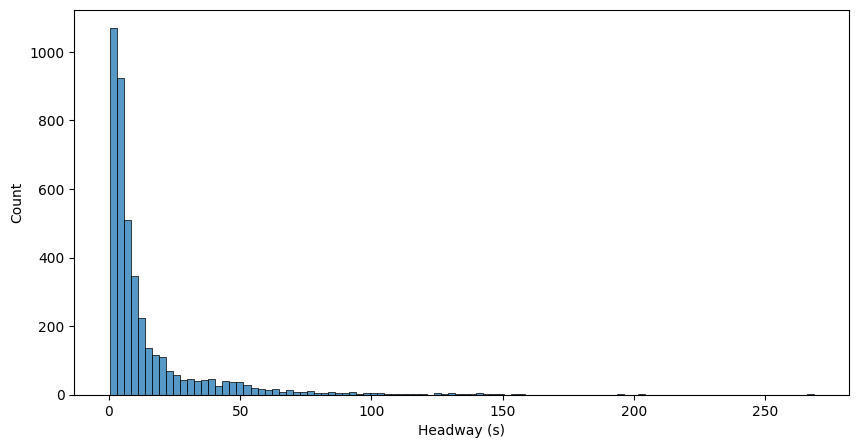

In [44]:
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

sns.histplot(dist, x="mean", bins=100)

plt.xlabel("Headway (s)")


Text(0.5, 0, 'Headway (s)')

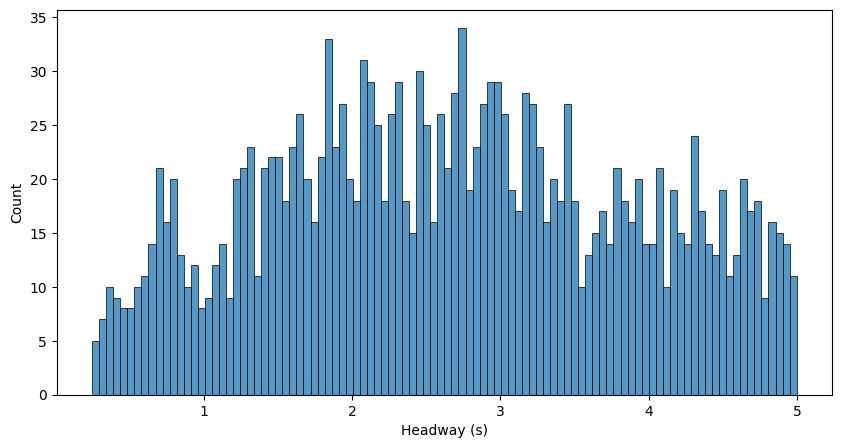

In [45]:
plt.figure(figsize=(10, 5))

sns.histplot(dist.loc[dist["mean"] < 5], x="mean", bins=100)

plt.xlabel("Headway (s)")


In [46]:
dist.to_parquet(
    ROOT / "data" / "2023-01-13" / "headway.parquet"
)

In [24]:
# from math import ceil
# import numpy as np
# from scipy import linalg


# def lowess(x, y, f=2. / 3., iter=3):
#     """lowess(x, y, f=2./3., iter=3) -> yest
#     Lowess smoother: Robust locally weighted regression.
#     The lowess function fits a nonparametric regression curve to a scatterplot.
#     The arrays x and y contain an equal number of elements; each pair
#     (x[i], y[i]) defines a data point in the scatterplot. The function returns
#     the estimated (smooth) values of y.
#     The smoothing span is given by f. A larger value for f will result in a
#     smoother curve. The number of robustifying iterations is given by iter. The
#     function will run faster with a smaller number of iterations.
#     """
#     n = len(x)
#     r = int(ceil(f * n))
#     h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
#     w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
#     w = (1 - w ** 3) ** 3
#     yest = np.zeros(n)
#     delta = np.ones(n)
#     for _ in range(iter):
#         for i in range(n):
#             weights = delta * w[:, i]
#             b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
#             A = np.array([[np.sum(weights), np.sum(weights * x)],
#                           [np.sum(weights * x), np.sum(weights * x * x)]])
#             beta = linalg.solve(A, b)
#             yest[i] = beta[0] + beta[1] * x[i]

#         residuals = y - yest
#         s = np.median(np.abs(residuals))
#         delta = np.clip(residuals / (6.0 * s), -1, 1)
#         delta = (1 - delta ** 2) ** 2

#     return yest


### Filter Vehicles That Don't Travel at Least 100m in East Thru


In [175]:
veh_df = radar.df[radar.df.box.str.contains("East thru")].copy()

veh_df["stop_distance"] = np.linalg.norm(
    veh_df[["f32_positionX_m", "f32_positionY_m"]].values
    - radar.approaches[0][1].end_point,
    axis=1,
)


In [11]:
stop_vehicles = veh_df.groupby(veh_df["ui32_objectID"]).agg(
    {
        "stop_distance": lambda x: x.max() - x.min(),
    }
)

stop_vehicles = stop_vehicles.loc[stop_vehicles.stop_distance >= 120].index.values

veh_df = veh_df.loc[veh_df.ui32_objectID.isin(stop_vehicles)].copy()


NameError: name 'veh_df' is not defined

In [187]:
# plot the results
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pwlf
from src.lowess import lowess

# _veh_df = veh_df.loc[veh_df.ui32_objectID == veh_df.ui32_objectID.sample(1).values[0]]
_veh_df = veh_df.loc[veh_df.ui32_objectID == 50367]

x = (_veh_df.dt - _veh_df.dt.min()).dt.total_seconds()
y = _veh_df["f32_velocityInDir_mps"]

a = pd.Series(y) == 0
zero_sum = a.cumsum() - a.cumsum().where(~a).ffill().fillna(0).astype(int)

# keep only where zero_sum is < 3
x = x.loc[zero_sum < 3].values
y = y.loc[zero_sum < 3].values.astype(float)

# crop out long segments of all 0. They have to be sequential
# create a figure with a secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])


# distance = _veh_df[['f32_positionX_m', 'f32_positionY_m']].diff().apply(np.linalg.norm, axis=1).cumsum().fillna(0)
# distance = distance.loc[zero_sum < 3].values.astype(float)

smoothed = lowess(y=y, x=x, f=1 / 5, n_iter=1)
gradient_accel = np.gradient(smoothed, x)

raw_accel_gradient = np.gradient(y, x)
fig.add_scatter(
    x=x,
    y=smoothed,
    name="velocity - Lowess",
    mode="lines",
)
fig.add_scatter(
    x=x,
    y=gradient_accel,
    name=f"lowess acceleration - gradient {gradient_accel.mean():.3f} m/s^2",
    mode="lines",
    secondary_y=True,
)


fig.add_scatter(
    x=x,
    y=y,
    name="velocity True",
    mode="lines",
)

# fig.add_scatter(
#     x=x[1:],
#     y=raw_accel,
#     name=f"acceleration 'true' {raw_accel.mean():.3f} m/s^2",
#     mode="lines",
#     secondary_y=True,
# )

fig.add_scatter(
    x=x,
    y=raw_accel_gradient,
    name=f"acceleration 'true' - gradient {raw_accel_gradient.mean():.3f} m/s^2",
    mode="lines",
    secondary_y=True,
)


pwlf_model = pwlf.PiecewiseLinFit(x, y)
breaks = pwlf_model.fit(5)
slopes = pwlf_model.slopes
intercepts = pwlf_model.intercepts

for i, (b0, b1, slope, intercept) in enumerate(zip(breaks[:-1], breaks[1:], slopes, intercepts)):
    fig.add_scatter(
        x=[b0, b1],
        y=[intercept + slope * b0, intercept + slope * b1],
        name=f"pwlf - avg accel: {slopes.mean():.3f} m/s^2",
        mode="lines",
        showlegend=i < 1,
    )

    # add a annotation with the slope
    fig.add_annotation(
        x=(b0 + b1) / 2,
        y=intercept + slope * b0,
        text=f"accel: {slope:.2f} m/s^2<br>",
        font=dict(
            size=16,
        )
    )

fig.show()


In [141]:
sign_flips = np.where(np.diff(np.signbit(gradient_accel)))


In [142]:
accel_chunks = np.split(gradient_accel, sign_flips[0] + 1)
time_chunks = np.split(x, sign_flips[0] + 1)


In [143]:
fig = go.Figure()

for i, (chunk, time_chunk) in enumerate(zip(accel_chunks, time_chunks)):
    fig.add_scatter(
        x=time_chunk,
        y=chunk,
        name=f"acceleration chunk {i}",
        mode="lines",
    )

fig.show()


In [135]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from src.lowess import lowess


def get_xy(
    df,
):
    x = (df.dt - df.dt.min()).dt.total_seconds()
    y = df["f32_velocityInDir_mps"]
    a = y < 0.1
    zero_sum = a.cumsum() - a.cumsum().where(~a).ffill().fillna(0).astype(int)
    slicer = (zero_sum < 2) | (zero_sum.shift(1).fillna(1) > 0)
    return x.loc[slicer].values, y.loc[slicer].values.astype(float)


def get_lowess(x, y):
    return lowess(x=x, y=y, f=1 / 5, n_iter=1)


def get_acceleration(x, y):
    return np.gradient(y, x)


def get_splits(accel):
    # find consecutive accel/decel
    return np.where(np.diff(np.signbit(accel)))


def split_array(array, indices):
    return np.split(array, indices[0] + 1)



def get_true_acceleration_chunks(
    x,
    y,
):
    accel = get_acceleration(x, y)
    splits = get_splits(accel)
    times = split_array(x, splits)
    speed = split_array(y, splits)
    accel = split_array(accel, splits)
    for return_times, return_accel, speed in zip(times, accel, speed):
        time_diff = return_times[-1] - return_times[0]
        yield return_times[0], return_times[
            -1
        ], return_accel.mean(), time_diff, speed.mean(), 1, 1


def get_lowess_acceleration_chunks(
    x,
    y,
):
    lowess_y = get_lowess(x, y)
    lowess_y[lowess_y < 0] = 0
    accel = get_acceleration(x, lowess_y)
    splits = get_splits(accel)
    times = split_array(x, splits)
    speed = split_array(lowess_y, splits)
    accel = split_array(accel, splits)
    for return_times, return_accel, speed in zip(times, accel, speed):
        time_diff = return_times[-1] - return_times[0]
        yield return_times[0], return_times[
            -1
        ], return_accel.mean(), time_diff, speed.mean(), 1, 1


def get_pwlf_acceleration_chunks(
    x,
    y,
):
    pwlf_model = pwlf.PiecewiseLinFit(x, y)
    breaks = pwlf_model.fit(5)
    slopes = pwlf_model.calc_slopes()
    yHat = pwlf_model.predict(x)
    for i, (b0, b1) in enumerate(
        zip(
            breaks[:-1],
            breaks[1:],
        )
    ):
        slicer = (x >= b0) & (x < b1)
        x_sliced = x[slicer]
        if len(x_sliced) < 3:
            continue
        yHat_break = yHat[slicer]
        yAct_break = y[slicer]
        r2 = r2_score(yAct_break, yHat_break)
        mse = mean_squared_error(
            yAct_break,
            yHat_break,
        )
        yield b0, b1, slopes[i], b1 - b0, yHat_break.mean(), r2, mse


In [136]:
from tqdm import tqdm

error_vehicle_ids = []
vehicle_accel = []
for g, veh in tqdm(
    veh_df.groupby("ui32_objectID"), total=len(veh_df.ui32_objectID.unique())
):
    x, y = get_xy(veh)
    if len(x) < 3:
        continue
    try:
        vehicle_accel.extend(
            {
                "vehicle_id": g,
                "start": start,
                "end": end,
                "accel": accel,
                "time_diff": time_diff,
                "speed": speed,
                "r2": r2,
                "mse": mse,
            }
            for start, end, accel, time_diff, speed, r2, mse in get_lowess_acceleration_chunks(
                x, y
            )
        )
    except np.linalg.LinAlgError:
        error_vehicle_ids.append(g)
        break

    # for start, end, accel, time_diff, speed, r2, mse in get_pwlf_acceleration_chunks(x, y):
    #     print(f"start: {start:.3f} end: {end:.3f} accel: {accel:.3f} m/s^2 time: {time_diff:.3f} s speed: {speed:.3f} m/s r2: {r2:.3f} mse: {mse:.3f}


100%|██████████| 4405/4405 [00:14<00:00, 300.82it/s]


In [137]:
lowess_method = pd.DataFrame(vehicle_accel)

lowess_method.to_parquet(ROOT / "data" / "2023-01-13" / "lowess_method.parquet")

In [138]:
cruise_thresh = 0.1

lowess_method["type"] = np.where(
    lowess_method["accel"] > cruise_thresh, "accel", ""
)
lowess_method["type"] = np.where(
    lowess_method["accel"] < -1 * cruise_thresh, "decel", lowess_method["type"]
)

lowess_average = lowess_method.loc[(lowess_method['type'] == "accel") & (lowess_method['time_diff'] >= 3)].groupby(["vehicle_id", "type"]).apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)

In [139]:
lowess_average.describe()

count    1641.000000
mean        0.490864
std         0.240422
min         0.101690
25%         0.327036
50%         0.443974
75%         0.598256
max         2.313786
dtype: float64

In [129]:
lowess_average.describe()

count    1598.000000
mean        0.509763
std         0.246496
min         0.101661
25%         0.341993
50%         0.455102
75%         0.614352
max         2.313786
dtype: float64

### Using True Acceleration

In [94]:
from tqdm import tqdm

error_vehicle_ids = []
vehicle_accel = []
for g, veh in tqdm(
    veh_df.groupby("ui32_objectID"), total=len(veh_df.ui32_objectID.unique())
):
    x, y = get_xy(veh)
    if len(x) < 3:
        continue
    try:
        vehicle_accel.extend(
            {
                "vehicle_id": g,
                "start": start,
                "end": end,
                "accel": accel,
                "time_diff": time_diff,
                "speed": speed,
                "r2": r2,
                "mse": mse,
            }
            for start, end, accel, time_diff, speed, r2, mse in get_true_acceleration_chunks(
                x, y
            )
        )
    except np.linalg.LinAlgError:
        error_vehicle_ids.append(g)
        break

    # for start, end, accel, time_diff, speed, r2, mse in get_pwlf_acceleration_chunks(x, y):
    #     print(f"start: {start:.3f} end: {end:.3f} accel: {accel:.3f} m/s^2 time: {time_diff:.3f} s speed: {speed:.3f} m/s r2: {r2:.3f} mse: {mse:.3f}


100%|██████████| 4405/4405 [00:12<00:00, 339.49it/s]


In [95]:
true_method = pd.DataFrame(vehicle_accel)

# true_method.to_parquet(ROOT / "data" / "2023-01-13" / "lowess_method.parquet")

In [98]:
cruise_thresh = 0.1

true_method["type"] = np.where(
    true_method["accel"] > cruise_thresh, "accel", ""
)
true_method["type"] = np.where(
    true_method["accel"] < -1 * cruise_thresh, "decel", true_method["type"]
)

true_method = true_method.loc[true_method['accel'].abs() < 6]

true_average = true_method.loc[(true_method['type'] == "accel") & (true_method['time_diff'] >= 3)].groupby(["vehicle_id", "type"]).apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)

In [99]:
true_average.describe()

count    350.000000
mean       0.937660
std        0.665432
min        0.100453
25%        0.508646
50%        0.782659
75%        1.188680
max        5.018930
dtype: float64

<AxesSubplot: >

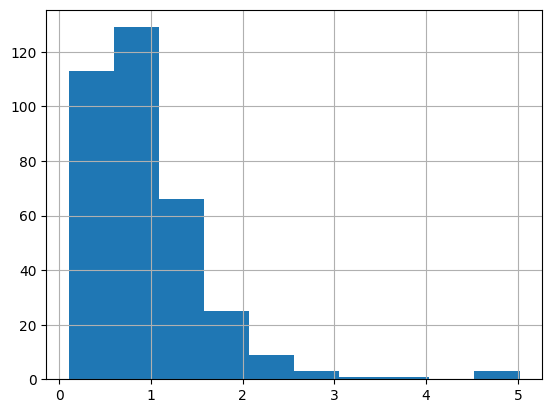

In [100]:
true_average.hist()

### Using Pwlf

In [348]:
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed

df = veh_df
id_col = "ui32_objectID"
time_col = "dt"
speed_col = "f32_velocityInDir_mps"


def process_trajectory(
    group_name,
    group,
):
    x, y = get_xy(group)
    if len(x) < 3:
        return []
    try:
        return [
            {
                "vehicle_id": group_name,
                "start": start,
                "end": end,
                "accel": accel,
                "time_diff": time_diff,
                "speed": speed,
                "r2": r2,
                "mse": mse,
            }
            for start, end, accel, time_diff, speed, r2, mse in get_pwlf_acceleration_chunks(
                x, y
            )
        ]
    except np.linalg.LinAlgError:
        return []


with tqdm_joblib(desc="process", total=df[id_col].nunique()) as progress_bar:
    pwlf_accels = Parallel(n_jobs=8)(
        delayed(process_trajectory)(
            *group,
        )
        for group in df.groupby(id_col)
    )


process: 100%|██████████| 4405/4405 [28:26<00:00,  2.58it/s] 


In [37]:
pwlf_accels = [item for sublist in pwlf_accels for item in sublist]
pwlf_method = pd.DataFrame(pwlf_accels)


NameError: name 'pwlf_accels' is not defined

In [101]:
# pwlf_method.to_parquet(ROOT / "data" / "2023-01-13" / "pwlf_method.parquet")
pwlf_method = pd.read_parquet(ROOT / "data" / "2023-01-13" / "pwlf_method.parquet")

### Analyzing the PWLF vs. Lowess

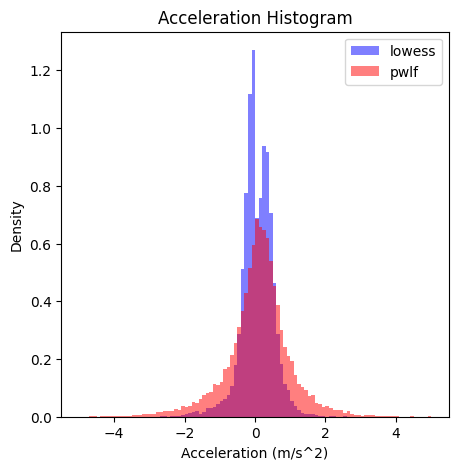

In [130]:
fig = plt.figure(figsize=(5, 5))
# create a histogram plot of accel
ax = fig.add_subplot(111)
ax.hist(
    lowess_method.accel,
    bins=100,
    range=(-5, 5),
    color="blue",
    alpha=0.5,
    label="lowess",
    density=True,
)

ax.hist(
    pwlf_method.accel,
    bins=100,
    range=(-5, 5),
    color="red",
    alpha=0.5,
    label="pwlf",
    density=True,
)

ax.set_xlabel("Acceleration (m/s^2)")
ax.set_ylabel("Density")
ax.set_title("Acceleration Histogram")
ax.legend()

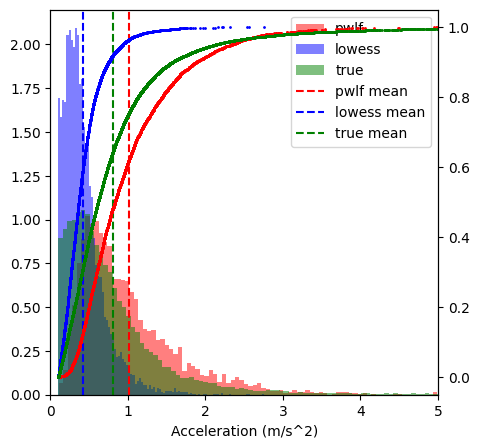

In [131]:
threshold = 0.1

pwlf_accel = pwlf_method.loc[(pwlf_method["accel"] > threshold) & (pwlf_method["r2"] > 0.9)]

lowess_accel = lowess_method.loc[
    (lowess_method["accel"] > threshold)
]

# create a histogram of the acceleration values
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(
    pwlf_accel["accel"],
    bins=100,
    label="pwlf",
    alpha=0.5,
    density=True,
    color="red",
)
ax.hist(
    lowess_accel["accel"],
    bins=100,
    label="lowess",
    alpha=0.5,
    density=True,
    color="blue",
)
ax.hist(
    true_method.loc[true_method["type"] == "accel"]["accel"],
    bins=100,
    label="true",
    alpha=0.5,
    density=True,
    color="green",
)


ax.set_xlabel("Acceleration (m/s^2)")

# create a ecdf of the acceleration values on the right y-axis
ax2 = ax.twinx()
ax2.scatter(
    np.sort(pwlf_accel["accel"].values),
    np.linspace(0, 1, len(pwlf_accel["accel"].values)),
    label="pwlf",
    alpha=1,
    s=1,
    color="red",
)

ax2.scatter(
    np.sort(lowess_accel["accel"].values),
    np.linspace(0, 1, len(lowess_accel["accel"].values)),
    label="lowess",
    alpha=1,
    # make markers smaller
    s=1,
    color="blue",
)

ax2.scatter(
    np.sort(true_method.loc[true_method["type"] == "accel"]["accel"].values),
    np.linspace(0, 1, len(true_method.loc[true_method["type"] == "accel"]["accel"].values)),
    label="true",
    alpha=1,
    # make markers smaller
    s=1,
    color="green",
)


# set x-axis limits
ax.set_xlim(0, 5)


# add a legend
ax.legend()

# add the mean acceleration to the plot
ax.axvline(
    pwlf_accel["accel"].mean(),
    color="red",
    linestyle="--",
    label="pwlf mean",
)

ax.axvline(
    lowess_accel["accel"].mean(),
    # make the color the same as the histogram
    color="blue",
    linestyle="--",
    label="lowess mean",
)

ax.axvline(
    true_method.loc[true_method["type"] == "accel"]["accel"].mean(),
    # make the color the same as the histogram
    color="green",
    linestyle="--",
    label="true mean",
)


# add the lines to the legend
ax.legend()



In [376]:
lowess_method = lowess_method.loc[lowess_method.time_diff > 0].copy()

In [132]:
# grouped pwlf acceleration
# mark acceleration values that are greater than 0.2 m/s^2 as type == acceleration
# mark acceleration values that are less than -0.2 m/s^2 as type == deceleration
pwlf_method["type"] = np.where(pwlf_method["accel"] > 0.2, "accel", "")
pwlf_method["type"] = np.where(pwlf_method["accel"] < -0.2, "decel", pwlf_method["type"])
lowess_method["type"] = np.where(
    lowess_method["accel"] > 0.2, "accel", ""
)
lowess_method["type"] = np.where(
    lowess_method["accel"] < -0.2, "decel", lowess_method["type"]
)

avg_accel = pwlf_method.loc[(pwlf_method['type'] == "accel") & (pwlf_method['time_diff'] >= 3)].groupby(["vehicle_id", "type"]).apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)

lowess_average = lowess_method.loc[(lowess_method['type'] == "accel") & (lowess_method['time_diff'] >= 3)].groupby(["vehicle_id", "type"]).apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)

true_average = true_method.loc[(true_method['type'] == "accel") & (true_method['time_diff'] >= 1)].groupby(["vehicle_id", "type"]).apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)

In [133]:
lowess_average

vehicle_id  type 
35270       accel    0.416321
35273       accel    0.610717
35278       accel    0.624502
35391       accel    0.319918
35410       accel    0.323924
                       ...   
64415       accel    0.315563
64416       accel    0.260517
64424       accel    0.309093
64430       accel    0.391910
64451       accel    0.319290
Length: 1547, dtype: float64

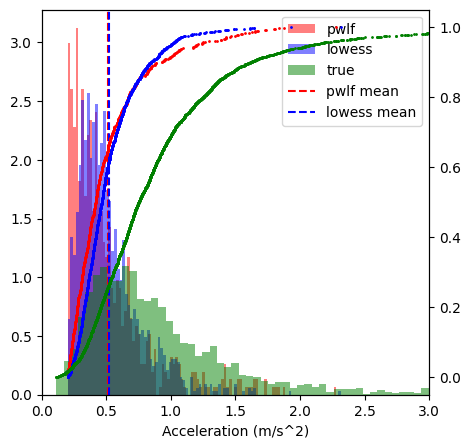

In [134]:
# pwlf_accel = pwlf_method.loc[(pwlf_method["accel"] > threshold) & (pwlf_method["r2"] > 0.9) & (pwlf_method["time_diff"] > 1.5)]

# create a histogram of the acceleration values
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(
    # pwlf_accel["accel"],
    avg_accel,
    bins=100,
    label="pwlf",
    alpha=0.5,
    density=True,
    color="red",
)
ax.hist(
    lowess_average,
    bins=100,
    label="lowess",
    alpha=0.5,
    density=True,
    color="blue",
)

ax.hist(
    true_average,
    bins=100,
    label="true",
    alpha=0.5,
    density=True,
    color="green",
)

ax.set_xlabel("Acceleration (m/s^2)")

# create a ecdf of the acceleration values on the right y-axis
ax2 = ax.twinx()
ax2.scatter(
    np.sort(avg_accel.values),
    np.linspace(0, 1, len(avg_accel.values)),
    label="pwlf",
    alpha=1,
    s=1,
    color="red",
)

ax2.scatter(
    np.sort(lowess_average.values),
    np.linspace(0, 1, len(lowess_average.values)),
    label="lowess",
    alpha=1,
    # make markers smaller
    s=1,
    color="blue",
)

ax2.scatter(
    np.sort(true_average.values),
    np.linspace(0, 1, len(true_average.values)),
    label="true",
    alpha=1,
    # make markers smaller
    s=1,
    color="green",
)

# add the mean acceleration to the plot
ax.axvline(
    avg_accel.mean(),
    color="red",
    linestyle="--",
    label="pwlf mean",
)

ax.axvline(
    lowess_average.mean(),
    # make the color the same as the histogram
    color="blue",
    linestyle="--",
    label="lowess mean",
)

# add the lines to the legend
ax.legend()

# set x-axis limits
ax.set_xlim(0, 3)


# add a legend
ax.legend()


In [407]:
# grouped pwlf acceleration
# mark acceleration values that are greater than 0.2 m/s^2 as type == acceleration
# mark acceleration values that are less than -0.2 m/s^2 as type == deceleration

avg_accel = pwlf_method.loc[(pwlf_method['type'] == "decel") & (pwlf_method['time_diff'] >= 1)].groupby(["vehicle_id", "type"]).apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)

lowess_average = lowess_method.loc[(lowess_method['type'] == "decel") & (lowess_method['time_diff'] >= 1)].groupby(["vehicle_id", "type"]).apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)

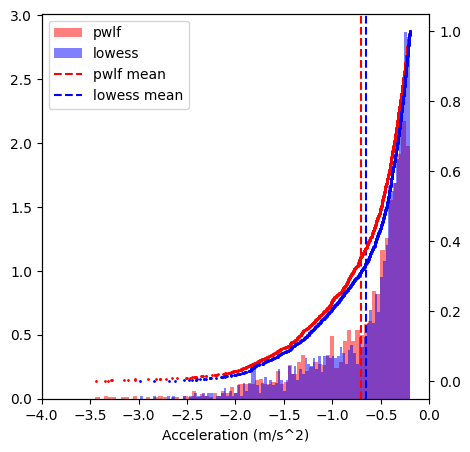

In [408]:
# pwlf_accel = pwlf_method.loc[(pwlf_method["accel"] > threshold) & (pwlf_method["r2"] > 0.9) & (pwlf_method["time_diff"] > 1.5)]

# create a histogram of the acceleration values
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(
    # pwlf_accel["accel"],
    avg_accel,
    bins=100,
    label="pwlf",
    alpha=0.5,
    density=True,
    color="red",
)
ax.hist(
    lowess_average,
    bins=100,
    label="lowess",
    alpha=0.5,
    density=True,
    color="blue",
)
ax.set_xlabel("Acceleration (m/s^2)")

# create a ecdf of the acceleration values on the right y-axis
ax2 = ax.twinx()
ax2.scatter(
    np.sort(avg_accel.values),
    np.linspace(0, 1, len(avg_accel.values)),
    label="pwlf",
    alpha=1,
    s=1,
    color="red",
)

ax2.scatter(
    np.sort(lowess_average.values),
    np.linspace(0, 1, len(lowess_average.values)),
    label="lowess",
    alpha=1,
    # make markers smaller
    s=1,
    color="blue",
)

# add the mean acceleration to the plot
ax.axvline(
    avg_accel.mean(),
    color="red",
    linestyle="--",
    label="pwlf mean",
)

ax.axvline(
    lowess_average.mean(),
    # make the color the same as the histogram
    color="blue",
    linestyle="--",
    label="lowess mean",
)

# add the lines to the legend
ax.legend()

# set x-axis limits
ax.set_xlim(-4, 0)


# add a legend
ax.legend()


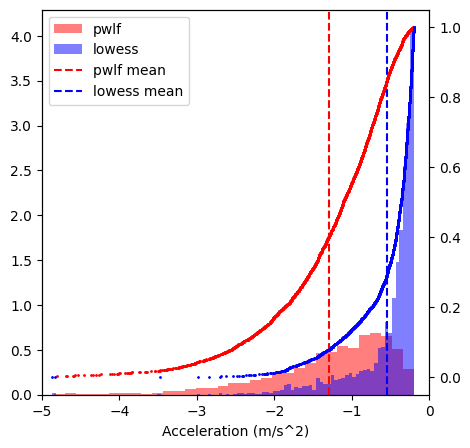

In [412]:
threshold = 0.2

pwlf_accel = pwlf_method.loc[(pwlf_method["accel"] < -1 * threshold) & (pwlf_method["r2"] > 0.9)]

lowess_accel = lowess_method.loc[
    (lowess_method["accel"] < -1 * threshold)
    & (lowess_method["accel"] > -5)
]

# create a histogram of the acceleration values
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(
    pwlf_accel["accel"],
    bins=100,
    label="pwlf",
    alpha=0.5,
    density=True,
    color="red",
)
ax.hist(
    lowess_accel["accel"],
    bins=100,
    label="lowess",
    alpha=0.5,
    density=True,
    color="blue",
)
ax.set_xlabel("Acceleration (m/s^2)")

# create a ecdf of the acceleration values on the right y-axis
ax2 = ax.twinx()
ax2.scatter(
    np.sort(pwlf_accel["accel"].values),
    np.linspace(0, 1, len(pwlf_accel["accel"].values)),
    label="pwlf",
    alpha=1,
    s=1,
    color="red",
)

ax2.scatter(
    np.sort(lowess_accel["accel"].values),
    np.linspace(0, 1, len(lowess_accel["accel"].values)),
    label="lowess",
    alpha=1,
    # make markers smaller
    s=1,
    color="blue",
)


# add the mean acceleration to the plot
ax.axvline(
    pwlf_accel["accel"].mean(),
    color="red",
    linestyle="--",
    label="pwlf mean",
)

ax.axvline(
    lowess_accel["accel"].mean(),
    # make the color the same as the histogram
    color="blue",
    linestyle="--",
    label="lowess mean",
)

# set x-axis limits
ax.set_xlim(-5, 0)


# add a legend
ax.legend()



In [193]:
fig = go.Figure()


for name, approach in radar.approaches:
    fig.add_trace(
        go.Scatter(
            x=[x for x, y in approach.polygon.exterior.coords],
            y=[y for x, y in approach.polygon.exterior.coords],
            name=name,
        )
    )


i = 0
veh = _veh_df
fig.add_trace(
    go.Scatter(
        x=veh["f32_positionX_m"],
        y=veh["f32_positionY_m"],
    )
)

fig.update_layout(height=600, width=600)
fig.show()


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


TIME_COL = "relative_time"
SPD_COL = "f32_velocityInDir_mps"
ABS_TIME_COL = "dt"

from src.pwlfer import process_trajectories, classify

veh_df["relative_time"] = veh_df.groupby("ui32_objectID")["dt"].transform(
    lambda x: (x - x.min()).dt.total_seconds()
)
res = process_trajectories(
    veh_df,
    time_col="relative_time",
    speed_col="f32_velocityInDir_mps",
    id_col="ui32_objectID",
    abs_time_col="dt",
    n_jobs=8,
)
summary_df = pd.DataFrame([{**v, **l} for v in res for l in v.pop("line_fits")])


process: 100%|██████████| 4151/4151 [14:14<00:00,  4.86it/s]


In [ ]:
summary_df["type"] = summary_df.apply(classify, axis=1)
summary_df["minimum_time"] = summary_df["end"] - summary_df["start"]


In [ ]:
summary_df.to_parquet(
    ROOT / "data" / "rw_east_thru_summary.parquet",
    **{"coerce_timestamps": "us", "allow_truncated_timestamps": True}
)


In [ ]:
summary_df = pd.read_parquet(
    ROOT / "data" / "rw_east_thru_summary.parquet",
)


### Plot Some of the Results


In [ ]:
import os
import plotly.express as px

n = 1
vehicle_ids = summary_df.loc[(summary_df["slope"] > 1) & (summary_df["r2"] > 0.9)][
    "vehicle_id"
].unique()

veh_df["relative_time"] = veh_df.groupby("ui32_objectID")["dt"].transform(
    lambda x: (x - x.min()).dt.total_seconds()
)


# for loop to plot 100 vehicles
for i in range(n):
    # get the vehicle id
    vehicle_id = vehicle_ids[i]
    # get the line fits
    vehicle_df = summary_df[summary_df["vehicle_id"] == vehicle_id]

    # get the vehicle data
    vehicle_data = veh_df[veh_df["ui32_objectID"] == vehicle_id].copy()

    # create the figure
    fig = px.line(vehicle_data, x="relative_time", y="f32_velocityInDir_mps")

    line_fits = vehicle_df.to_dict(orient="records")

    # loop through the line fits
    for line_fit in line_fits:
        # get the break
        break_ = line_fit["break"]
        # get the slope
        slope = line_fit["slope"]
        # get the r2
        r2 = line_fit["r2"]
        # get the type
        type_ = line_fit["type"]
        # get the mean speed
        y0 = line_fit["y0"]

        # get the min and max time
        min_time = line_fit["start"]
        max_time = line_fit["end"]
        # add the line
        fig.add_scatter(
            x=[min_time, max_time],
            y=[slope * (min_time) + y0, slope * (max_time) + y0],
            mode="lines",
        )
        # add text of the slope to the middle of the line
        fig.add_annotation(
            x=min_time,
            y=(slope * (min_time) + y0) + 2,
            text=f"accel: {slope:.2f} m/s^2<br>r^2: {r2:.2f}<br>type: {type_}<br>speed: {line_fit['speed']:.2f} mps",
            showarrow=False,
            font=dict(size=14),
        )


fig.show()
